In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

In [2]:
N_EPOCHS = 10000                            ## 4000
batch_size = 16                             ## 5    ## 32
learning_rate =  0.1                        ## 0.01   ## 1e-5 


## 0.0001  experimentally seemed okay 
learning_rate_pdfcontrol  =  0.0001     ## 0.00001       ## 0.000001

# define mean and standard deviation of target Gaussian distribution (impulse function)
mean_impulse = 0.
std_impulse  = 0.01

h = 0.7            ## 0.05     ## 0.03                    ## 0.05 >

## experimentally 20 seemed okay 
N_error_range = 20          ## 20  ## 10   ## error between pred and real range (-20, 20)

switch_threshold = 0.90

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

In [3]:
CFD_raw_data = pd.read_csv('data/winequality-red.csv')

In [4]:
headers_list = CFD_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
12
(0, 'fixed acidity')
(1, 'volatile acidity')
(2, 'citric acid')
(3, 'residual sugar')
(4, 'chlorides')
(5, 'free sulfur dioxide')
(6, 'total sulfur dioxide')
(7, 'density')
(8, 'pH')
(9, 'sulphates')
(10, 'alcohol')
(11, 'quality')


In [5]:
CFDdata_np = CFD_raw_data.to_numpy()
print(CFDdata_np)
print(CFDdata_np.shape)

[[ 7.4    0.7    0.    ...  0.56   9.4    5.   ]
 [ 7.8    0.88   0.    ...  0.68   9.8    5.   ]
 [ 7.8    0.76   0.04  ...  0.65   9.8    5.   ]
 ...
 [ 6.3    0.51   0.13  ...  0.75  11.     6.   ]
 [ 5.9    0.645  0.12  ...  0.71  10.2    5.   ]
 [ 6.     0.31   0.47  ...  0.66  11.     6.   ]]
(1599, 12)


In [6]:
input_indeces  = [1, 2, 3, 4, 9, 11]
output_indeces = [5, 6, 7, 8, 10]  

In [7]:
X = CFDdata_np[:, input_indeces]

y = CFDdata_np[:, output_indeces]

print(X.shape)
print(y.shape)

(1599, 6)
(1599, 5)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1279, 6)
(320, 6)
(1279, 5)
(320, 5)


In [10]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

In [11]:
## for scaling

epsilon = 0.0001

x_means      =  X_train_tr.mean(0, keepdim=True)
x_deviations =  X_train_tr.std(0, keepdim=True) + epsilon

X_train_tr_scaled = (X_train_tr - x_means) / x_deviations
X_test_tr_scaled  = (X_test_tr  - x_means) / x_deviations

In [12]:
## standardize the y outputs

y_means      = y_train_tr.mean(0, keepdim=True)
y_deviations = y_train_tr.std(0,  keepdim=True) + epsilon

y_train_tr_scaled = (y_train_tr - y_means) / y_deviations
y_test_tr_scaled  = (y_test_tr - y_means) / y_deviations


### Now, we call the Fit & DataLoader

In [13]:
def func_plot_performance(list_metric, the_string):
    
    list_samples = [i for i in range(len(list_metric))]
    
    plt.figure(figsize=(13,4))
    
    plt.scatter(list_samples, list_metric)
    
    ## plt.xlim(-1, 1)
    plt.ylim(0.5, 1.03)
    
    plt.title('metric during training ' + the_string)
    plt.xlabel('iteration/epoch')
    plt.ylabel('R**2')
    ## plt.legend()
    
    file_name = '300dpiShaft' + the_string + '.png'
    plt.savefig(file_name, dpi=300)

    plt.show()

In [14]:
def fit_y_scaled(num_epochs, model, loss_fn, opt):
    list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
            
    func_plot_performance(list_metric, "No PDF shaping")
            
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))

In [15]:
def fit_y_scaled_PDF(num_epochs, model, loss_fn, loss_fn_PDF, opt):
    list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_descaled, pred_scaled = model(xb)
            
            if epoch < int(num_epochs * switch_threshold):
                loss = loss_fn(pred_scaled, yb)
            else:
                opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )
                loss = loss_fn_PDF(pred_scaled, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        pred_descaled, pred_scaled = model(X_train_tr)
        r2_avg = torch.mean(torch.tensor(r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  )))
        list_metric.append(r2_avg.detach().numpy())
            
    func_plot_performance(list_metric, "With PDF shaping")
            
         
    pred_descaled, pred_scaled = model(X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,                   y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(),  y_train_tr_scaled.numpy()  ))

In [16]:
## define dataset
train_ds = TensorDataset(X_train_tr, y_train_tr_scaled)

## define dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

### Now, we define the various Architectures we will use to train and experiment

In [17]:
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 5) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

In [18]:
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 5)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

In [19]:
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(6, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 5)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

In [20]:
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(6, 5)       
        
        ## F2
        self.f2_linear1 = nn.Linear(6, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 5)       
        self.f2_dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

### Here, we define the Impulse Function for PDF Shaping 

Uses a Gaussian

In [21]:
def ImpulseGaussian(x, mu, sigma): 
   
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   ) * torch.sqrt(torch.tensor(sigma) )    )
    
    right = torch.exp(   -(x - mu)**2 / (2 * sigma)    )
    
    vector_vals = left * right
    
    return vector_vals         ## .unsqueeze(0)

### Here, we define the Kernel Density Function for PDF Approximation 

In [22]:
def kernel_density(x_range, the_errors, h): 
    
    x_range = x_range.unsqueeze(0)
   
    the_errors = the_errors.unsqueeze(2)
    
    
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   )  )
    
    right = torch.exp(   -((x_range - the_errors)/h)**2 / (2)    )
    
    vector_vals = left * right
    
    density         = torch.mean( vector_vals, 0) / h
             
    return density

### Here, we define the Custom Loss Function for PDF Shaping 

In [23]:
def my_loss(output, target):
    
    x = torch.arange(-N_error_range, N_error_range, 0.01)                        ## the error is in this range 
    
    error = output.float() - target.float() 
    
    basisFunc   =  kernel_density(x, error, h)
    
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)  
    
    diff = (  impulseFunc.float() - basisFunc.float()  )        ## * h         ## h is ?? 
    
    loss = torch.mean(   (   diff  )**2    )
    
    return loss

### Results for g(x) = F1(x) + F2(x) with No PDF shaping
F1 = Linear

F2 = Nonlinear

In [24]:
def print_individual_Rsquare(pred_descaled, y_test_tr):
    vector_pred_descaled = pred_descaled.detach().numpy()
    vector_y_test_tr     = y_test_tr.numpy()

    for i in range(len(output_indeces)):
        ## print(vector_pred_descaled.shape)
        print("*****")
        print("*****")
        print('Testing R**2 - Output: ' + str(i), r2_score( vector_pred_descaled[:, i], vector_y_test_tr[:, i] ) )
        

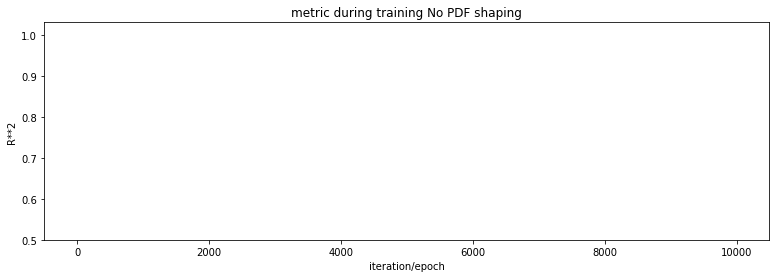

Training loss: tensor(0.8274, grad_fn=<MseLossBackward0>)
Training R**2: -1.5343571077536882
Test loss - scaled: tensor(0.9573, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(235.8778, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -2.533810117731825
Testing R**2 - descaled: -2.533810793993561
*****
*****
Testing R**2 - Output: 0 -6.900551388147799
*****
*****
Testing R**2 - Output: 1 -2.909959807229931
*****
*****
Testing R**2 - Output: 2 -1.1574747466829014
*****
*****
Testing R**2 - Output: 3 -1.2301466290125593
*****
*****
Testing R**2 - Output: 4 -0.47092144085601095


In [25]:
model = F1plusF2_SIO(x_means, x_deviations, y_means, y_deviations)
opt = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,                   y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,                 y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),    y_test_tr_scaled.numpy()  ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(),  y_test_tr.numpy()         ))

print_individual_Rsquare(pred_descaled, y_test_tr)

In [26]:
list_preds = []
list_reals = []

for i in range(len(X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(X_test_tr[i])
    ## print(  preds_descaled.shape  )
    ## print(  preds_descaled  )
    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = y_test_tr[i].detach().numpy()
    ## print(np_pred.shape)
    ## print(np_real.shape)

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(15.745396, 14.0)
(40.400772, 46.0)
(0.99605376, 0.9971)
(3.330483, 3.24)
(10.44206, 9.6)
**************************************************
preds, real
(16.439043, 21.0)
(48.90145, 102.0)
(0.9963701, 0.996)
(3.3357313, 3.39)
(9.813276, 9.5)
**************************************************
preds, real
(17.190546, 17.0)
(59.556133, 34.0)
(0.99712306, 1.0004)
(3.229067, 3.28)
(10.535853, 9.9)
**************************************************
preds, real
(15.5732355, 32.0)
(53.26676, 58.0)
(0.9972276, 0.998)
(3.2679513, 3.33)
(10.02123, 9.8)
**************************************************
preds, real
(13.252703, 18.0)
(33.883545, 34.0)
(0.9961574, 0.9948)
(3.2780786, 3.39)
(10.651569, 10.6)
**************************************************
preds, real
(15.387104, 35.0)
(49.782097, 72.0)
(0.99691844, 0.997)
(3.277678, 3.44)
(10.091335, 9.4)
**************************************************
preds, real
(16.145899, 23.0)


(12.507053, 25.0)
(47.431942, 57.0)
(0.9975819, 0.9983)
(3.1801555, 3.39)
(10.586005, 9.2)
**************************************************
preds, real
(8.019669, 6.0)
(34.55296, 17.0)
(0.99761915, 0.99565)
(3.1069238, 3.22)
(11.303629, 11.8)
**************************************************
preds, real
(22.26981, 5.0)
(68.10979, 31.0)
(0.9966902, 0.9993)
(3.3508215, 3.67)
(9.607548, 9.7)
**************************************************
preds, real
(14.690515, 6.0)
(44.00325, 24.0)
(0.9950602, 0.9963)
(3.2447424, 3.44)
(12.140397, 11.9)
**************************************************
preds, real
(15.92176, 23.0)
(56.858883, 78.0)
(0.99744815, 0.9987)
(3.2416115, 3.38)
(10.114266, 9.5)
**************************************************
preds, real
(12.816242, 14.0)
(32.46183, 36.0)
(0.9944526, 0.99364)
(3.3174856, 3.41)
(11.937566, 12.6)
**************************************************
preds, real
(22.495293, 12.0)
(91.66356, 67.0)
(0.99787533, 0.99565)
(3.3696778, 3.35)
(8.35

(15.309419, 9.0)
(50.153202, 17.0)
(0.9983349, 0.99655)
(3.3206573, 3.35)
(10.098367, 10.8)
**************************************************
preds, real
(11.380709, 33.0)
(41.91443, 85.0)
(0.9972094, 0.9962)
(3.1539614, 3.39)
(11.122513, 11.4)
**************************************************
preds, real
(18.054836, 15.0)
(61.370262, 115.0)
(0.99762285, 0.998)
(3.298305, 3.23)
(9.75536, 9.5)
**************************************************
preds, real
(14.505154, 28.0)
(35.763626, 54.0)
(0.9961637, 0.9956)
(3.2887144, 3.37)
(10.631194, 10.4)
**************************************************
preds, real
(10.845278, 6.0)
(21.31687, 12.0)
(0.99605346, 0.99495)
(3.229133, 3.44)
(11.5714245, 11.5)
**************************************************
preds, real
(14.508824, 11.0)
(42.59754, 44.0)
(0.9968009, 0.99888)
(3.322928, 3.31)
(10.188325, 9.5)
**************************************************
preds, real
(18.613518, 27.0)
(53.150158, 51.0)
(0.99638426, 0.99634)
(3.318597, 3.49)
(

(12.330913, 9.0)
(15.1065445, 15.0)
(0.99499345, 0.99514)
(3.3571055, 3.35)
(10.983975, 11.0)
**************************************************
preds, real
(22.329845, 13.0)
(73.731346, 50.0)
(1.0003358, 1.0015)
(3.2873209, 3.16)
(11.545848, 9.2)
**************************************************
preds, real
(18.899685, 27.0)
(57.754967, 63.0)
(0.99645174, 0.996)
(3.3453948, 3.28)
(9.601677, 9.2)
**************************************************
preds, real
(15.189939, 10.0)
(34.946747, 31.0)
(0.9956915, 0.995)
(3.3714554, 3.46)
(10.224306, 11.8)
**************************************************
preds, real
(13.903906, 8.0)
(40.187695, 38.0)
(0.9966256, 0.998)
(3.2654583, 3.47)
(10.6243105, 9.6)
**************************************************
preds, real
(15.9439945, 15.0)
(38.29128, 39.0)
(0.9957325, 0.99675)
(3.3723707, 3.37)
(10.168783, 9.2)
**************************************************
preds, real
(14.178751, 19.0)
(40.45739, 72.0)
(0.995004, 0.99543)
(3.271545, 3.39)
(1

FileNotFoundError: [Errno 2] No such file or directory: 'images/Y0ShaftRealToPredictedNoPDFshaping.png'

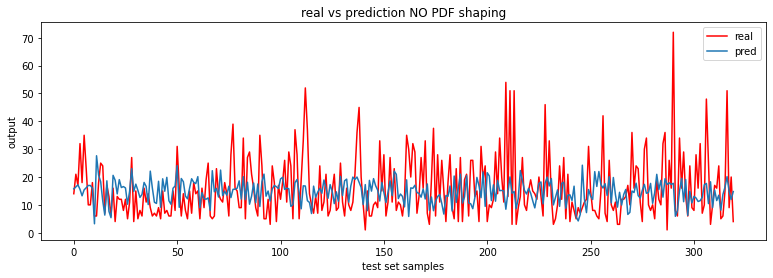

In [27]:
list_preds_y0 = [list_preds[i] for i in range(0, len(list_preds), 5)]
list_reals_y0 = [list_reals[i] for i in range(0, len(list_reals), 5)]


plt.figure(figsize=(13,4))


plt.plot(list_reals_y0, label= 'real', color='r' )
plt.plot(list_preds_y0, label= 'pred')

    
plt.title('real vs prediction NO PDF shaping')
plt.xlabel('test set samples')
plt.ylabel('output')
plt.legend()

plt.savefig('images/Y0ShaftRealToPredictedNoPDFshaping.png', dpi=300)

plt.show()